In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import openml

In [50]:
#!pip install openml

In [51]:
# Load the dataset from OpenML
dataset_id = 42721  # OpenML ID for "Airlines_DepDelay_1M"
dataset = openml.datasets.get_dataset(dataset_id, version = 1)

In [52]:
# Convert OpenML dataset to Pandas DataFrame
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
df = pd.concat([X, y], axis=1)

In [53]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,Origin,Dest,Distance,DepDelay
0,10,11,7,1300.0,1535.0,AA,LAX,HNL,2556.0,8.0
1,10,10,6,2035.0,2110.0,AA,OGG,HNL,100.0,-3.0
2,10,26,1,1200.0,1446.0,AA,JFK,LAX,2475.0,6.0
3,10,9,5,1145.0,1512.0,AA,JFK,SFO,2586.0,1.0
4,10,16,5,930.0,1149.0,AA,SFO,HNL,2399.0,0.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   Month          1000000 non-null  uint8   
 1   DayofMonth     1000000 non-null  uint8   
 2   DayOfWeek      1000000 non-null  uint8   
 3   CRSDepTime     1000000 non-null  float64 
 4   CRSArrTime     1000000 non-null  float64 
 5   UniqueCarrier  1000000 non-null  category
 6   Origin         1000000 non-null  category
 7   Dest           1000000 non-null  category
 8   Distance       1000000 non-null  float64 
 9   DepDelay       1000000 non-null  float64 
dtypes: category(3), float64(4), uint8(3)
memory usage: 38.2 MB


In [55]:
df.describe()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,Distance,DepDelay
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.496693,15.720187,3.944029,1333.301106,1492.460607,712.275619,8.191935
std,3.425559,8.787525,1.989687,473.972347,491.043639,556.836029,28.877186
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1197.000000
25%,4.000000,8.000000,2.000000,930.000000,1115.000000,313.000000,-3.000000
50%,6.000000,16.000000,4.000000,1325.000000,1520.000000,551.000000,0.000000
75%,9.000000,23.000000,6.000000,1725.000000,1911.000000,946.000000,7.000000
max,12.000000,31.000000,7.000000,2400.000000,2400.000000,4983.000000,2119.000000


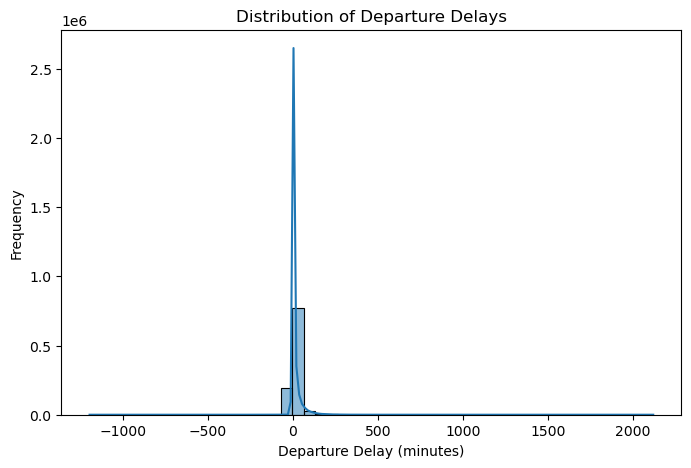

In [56]:
# Plot distribution of Departure Delays
plt.figure(figsize=(8, 5), dpi=100)
sns.histplot(df["DepDelay"], bins=50, kde=True)
plt.title("Distribution of Departure Delays")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

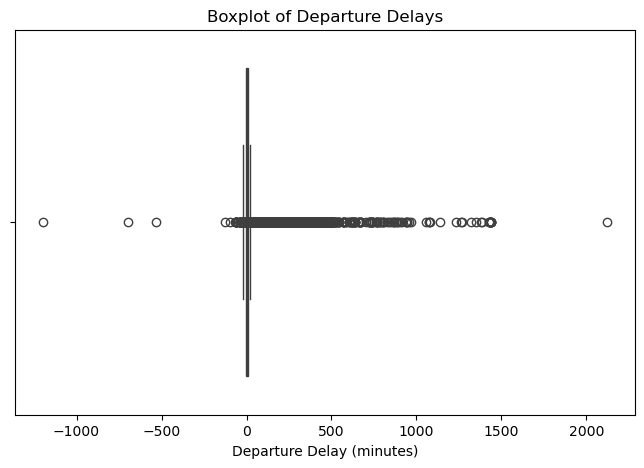

In [57]:
#Boxplot of Departure Delays
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["DepDelay"])
plt.title("Boxplot of Departure Delays")
plt.xlabel("Departure Delay (minutes)")
plt.show()

In [58]:
#remove outliers
Q1 = df["DepDelay"].quantile(0.25)  # First quartile
Q3 = df["DepDelay"].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset
df_filtered = df[(df["DepDelay"] >= lower_bound) & (df["DepDelay"] <= upper_bound)]

# Show new dataset shape
print("Original dataset size:", df.shape)
print("Filtered dataset size:", df_filtered.shape)

Original dataset size: (1000000, 10)
Filtered dataset size: (880367, 10)


In [59]:
# Load your cleaned dataset
df = df_filtered.copy()

In [60]:
# Convert DepDelay into binary classification (1 = delayed, 0 = on-time)
df["DelayStatus"] = (df["DepDelay"] > 0).astype(int)

# Drop the original `DepDelay` column since it's now converted
df.drop(columns=["DepDelay"], inplace=True)

# Check distribution of delayed vs. on-time flights
print(df["DelayStatus"].value_counts())


DelayStatus
0    593538
1    286829
Name: count, dtype: int64


In [61]:
df.dtypes

Month               uint8
DayofMonth          uint8
DayOfWeek           uint8
CRSDepTime        float64
CRSArrTime        float64
UniqueCarrier    category
Origin           category
Dest             category
Distance          float64
DelayStatus         int32
dtype: object

In [62]:
# Convert categorical columns to numerical using One-Hot Encoding
df = pd.get_dummies(df, columns=["UniqueCarrier", "Origin", "Dest"], drop_first=True)



In [63]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=["DelayStatus"])  # Features
y = df["DelayStatus"]  # Target variable

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (704293, 755)
Testing set size: (176074, 755)


In [ ]:
X_train.head()

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [50, 100],       # Number of trees in forest
    "max_depth": [None, 10],          # Maximum depth of each tree
    "min_samples_split": [2, 5],      # Minimum samples to split an internal node
    "min_samples_leaf": [1, 2],        # Minimum samples required at a leaf node
}

# Initialize Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all CPU cores for faster computation
    verbose=0  
)
